<a href="https://colab.research.google.com/github/paulrobustelli/AR_ligand_binding/blob/main/Setup_OpenMM_MDtraj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
!conda --version


conda 23.11.0


In [2]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install pandas numpy matplotlib


In [ ]:
!conda install -c conda-forge openmm

In [ ]:
!conda install -c conda-forge mdtraj

In [7]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt

## Using Google Drive to store topology data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our topology files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.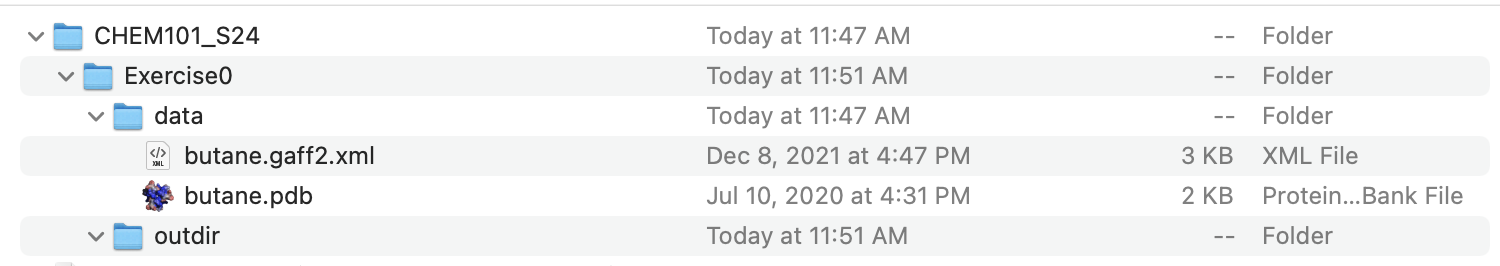

In [8]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


We're going to move our starting materials onto google drive in the subfolder CHEM101_S24/Exercise0

(Drag Folder from slack into into your top directory of google drive)

In [ ]:
ls drive/*

In [23]:
ls drive/MyDrive/CHEM101_S24/Exercise0/data

butane.gaff2.xml  butane.pdb
